<a href="https://colab.research.google.com/github/Salva13s/EnsambleMedMNIST/blob/main/Ensamble_VGG16_VGG19_RESNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalaciones necesarias

In [ ]:
!pip install medmnist
!pip install --upgrade medmnist
!pip install tensorflow

Imports necesarios

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Flatten
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.ensemble import VotingClassifier
import medmnist
from medmnist import INFO, Evaluator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import numpy as np
from skimage.color import gray2rgb
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import VGG19

Cargar y descargar la data

In [ ]:
data_flag = 'pneumoniamnist'

download = True

NUM_EPOCHS = 30
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
#load the data
train_dataset = DataClass(split='train',  download=download)
test_dataset = DataClass(split='test',  download=download)
val_dataset = DataClass(split="val", download=download)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


Tratamiento de datos

In [ ]:
class_names = ["normal", "pneumonia"]

In [ ]:
# Cargar los datos
train_images = train_dataset.imgs
train_labels = train_dataset.labels
test_images = test_dataset.imgs
test_labels = test_dataset.labels
val_images = val_dataset.imgs
val_labels = val_dataset.labels

In [ ]:
train_images_rgb = gray2rgb(train_images)
test_images_rgb = gray2rgb(test_images)
val_images_rgb = gray2rgb(val_images)

In [ ]:
train_images_resized = np.array([img_to_array(array_to_img(img).resize((32, 32))) for img in train_images_rgb])
test_images_resized = np.array([img_to_array(array_to_img(img).resize((32, 32))) for img in test_images_rgb])
val_images_resized = np.array([img_to_array(array_to_img(img).resize((32, 32))) for img in val_images_rgb])

In [ ]:
train_images = train_images_resized.astype('float32') / 255.0
test_images = test_images_resized.astype('float32') / 255.0
val_images = val_images_resized.astype('float32') / 255.0

Creacion de modelos (VGG16 + VGG19 + ResNET50) y agregacion de capas

In [ ]:
# Crear el modelo base de VGG16
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
# Congelar los pesos de las capas base
for layer in vgg_model.layers:
    layer.trainable = False

# Agregar una capa global de promediado y una capa densa para VGG16
vgg_output = vgg_model.output
vgg_output = GlobalAveragePooling2D()(vgg_output)
vgg_output = Dense(256, activation='relu')(vgg_output)



# Crear el modelo base de ResNet50
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
# Congelar los pesos de las capas base
for layer in resnet_model.layers:
    layer.trainable = False

# Agregar una capa global de promediado y una capa densa para ResNet50
resnet_output = resnet_model.output
resnet_output = GlobalAveragePooling2D()(resnet_output)
resnet_output = Dense(256, activation='relu')(resnet_output)

# Crear el modelo base de VGG19
vgg19_model = VGG19(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
# Congelar los pesos de las capas base
for layer in vgg19_model.layers:
    layer.trainable = False

# Renombrar las capas de VGG19 para evitar conflictos con VGG16
for layer in vgg19_model.layers:
    layer._name = layer.name + "_vgg19"

# Agregar una capa global de promediado y una capa densa para VGG19
vgg19_output = vgg19_model.output
vgg19_output = GlobalAveragePooling2D()(vgg19_output)
vgg19_output = Dense(256, activation='relu')(vgg19_output)

Concatenar salidas

In [ ]:
# Concatenar las salidas de VGG16, VGG19 y ResNet50
merged_output = tf.keras.layers.concatenate([vgg_output, vgg19_output, resnet_output])

Activacion

In [ ]:
# Agregar una capa densa final con función de activación sigmoide para la predicción
predictions = Dense(n_classes, activation='sigmoid')(merged_output)

Modelo nuevo ensamblado

In [ ]:
# Crear el modelo ensamblado con VGG16, VGG19 y ResNet50
ensemble_model = Model(inputs=[vgg_model.input, vgg19_model.input, resnet_model.input], outputs=predictions)

Compilar modelo

In [ ]:
# Compilar el modelo
optimizer = Adam(lr=lr)
ensemble_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',"AUC","binary_accuracy","TruePositives","TrueNegatives","FalsePositives","FalseNegatives"])

In [ ]:
train_labels = to_categorical(train_labels, num_classes=n_classes)
test_labels = to_categorical(test_labels, num_classes=n_classes)
val_labels = to_categorical(val_labels, num_classes=n_classes)

Callback y entrenamiento

In [ ]:
# Crear el callback de EarlyStopping
early_stopping_callback = EarlyStopping(monitor='loss', patience=3)

In [ ]:
history = ensemble_model.fit(
    [train_images, train_images, train_images], train_labels,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=([val_images, val_images, val_images], val_labels),
    callbacks=[early_stopping_callback]
)


Epoch 1/30
37/37 [==============================] - 9s 86ms/step - loss: 0.4631 - accuracy: 0.7878 - auc: 0.8703 - binary_accuracy: 0.7875 - true_positives: 3661.0000 - true_negatives: 3754.0000 - false_positives: 954.0000 - false_negatives: 1047.0000 - val_loss: 0.2895 - val_accuracy: 0.8683 - val_auc: 0.9491 - val_binary_accuracy: 0.8712 - val_true_positives: 456.0000 - val_true_negatives: 457.0000 - val_false_positives: 67.0000 - val_false_negatives: 68.0000
Epoch 2/30
37/37 [==============================] - 1s 17ms/step - loss: 0.2468 - accuracy: 0.8944 - auc: 0.9641 - binary_accuracy: 0.8936 - true_positives: 4205.0000 - true_negatives: 4209.0000 - false_positives: 499.0000 - false_negatives: 503.0000 - val_loss: 0.2364 - val_accuracy: 0.9027 - val_auc: 0.9703 - val_binary_accuracy: 0.9055 - val_true_positives: 476.0000 - val_true_negatives: 473.0000 - val_false_positives: 51.0000 - val_false_negatives: 48.0000
Epoch 3/30
37/37 [==============================] - 1s 17ms/step - lo

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'auc', 'binary_accuracy', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives', 'val_loss', 'val_accuracy', 'val_auc', 'val_binary_accuracy', 'val_true_positives', 'val_true_negatives', 'val_false_positives', 'val_false_negatives'])


Metricas

In [ ]:
print("Perdida en set de entrenamiento",history_dict["loss"][len(history_dict["loss"])-1])
print("Perdida en set de validacion",history_dict["val_loss"][len(history_dict["val_loss"])-1])
print("------------------------------------------------------------------------------------")
print("Accuracy en set de entrenamiento",history_dict["accuracy"][len(history_dict["accuracy"])-1])
print("Accuracy en set de validacion",history_dict["val_accuracy"][len(history_dict["val_accuracy"])-1])
print("------------------------------------------------------------------------------------")
print("Auc en set de entrenamiento",history_dict["auc"][len(history_dict["auc"])-1])
print("Auc en set de validacion",history_dict["val_auc"][len(history_dict["val_auc"])-1])
print("------------------------------------------------------------------------------------")
print("Binary_accuracy en set de entrenamiento",history_dict["binary_accuracy"][len(history_dict["binary_accuracy"])-1])
print("Binary_accuracy en set de validacion",history_dict["val_binary_accuracy"][len(history_dict["val_binary_accuracy"])-1])

Perdida en set de entrenamiento 0.10703819990158081
Perdida en set de validacion 0.09131539613008499
------------------------------------------------------------------------------------
Accuracy en set de entrenamiento 0.9604927897453308
Accuracy en set de validacion 0.9656488299369812
------------------------------------------------------------------------------------
Auc en set de entrenamiento 0.9926621317863464
Auc en set de validacion 0.9952909350395203
------------------------------------------------------------------------------------
Binary_accuracy en set de entrenamiento 0.9604927897453308
Binary_accuracy en set de validacion 0.9666030406951904


In [ ]:
print("Verdaderos negativos set entrenamiento: ",history_dict["true_negatives"][len(history_dict["true_negatives"])-1])
print("------------------------------------------------")
print("Verdaderos negativos set de testeo: ",history_dict["val_true_negatives"][len(history_dict["val_true_negatives"])-1])
print("------------------------------------------------")
print("Verdaderos positivos set entrenamiento: ",history_dict["true_positives"][len(history_dict["true_positives"])-1])
print("------------------------------------------------")
print("Verdaderos positivos set de testeo: ",history_dict["val_true_positives"][len(history_dict["val_true_positives"])-1])
print("------------------------------------------------")
print("Falsos negativos set entrenamiento: ",history_dict["false_negatives"][len(history_dict["false_negatives"])-1])
print("------------------------------------------------")
print("Falsos negativos set de testeo: ",history_dict["val_false_negatives"][len(history_dict["val_false_negatives"])-1])
print("------------------------------------------------")
print("Falsos positivos set entrenamiento: ",history_dict["false_positives"][len(history_dict["false_positives"])-1])
print("------------------------------------------------")
print("Falsos positivos set de testeo: ",history_dict["val_false_positives"][len(history_dict["val_false_positives"])-1])

Verdaderos negativos set entrenamiento:  4525.0
------------------------------------------------
Verdaderos negativos set de testeo:  507.0
------------------------------------------------
Verdaderos positivos set entrenamiento:  4519.0
------------------------------------------------
Verdaderos positivos set de testeo:  506.0
------------------------------------------------
Falsos negativos set entrenamiento:  189.0
------------------------------------------------
Falsos negativos set de testeo:  18.0
------------------------------------------------
Falsos positivos set entrenamiento:  183.0
------------------------------------------------
Falsos positivos set de testeo:  17.0


Graficos

<Figure size 640x480 with 0 Axes>

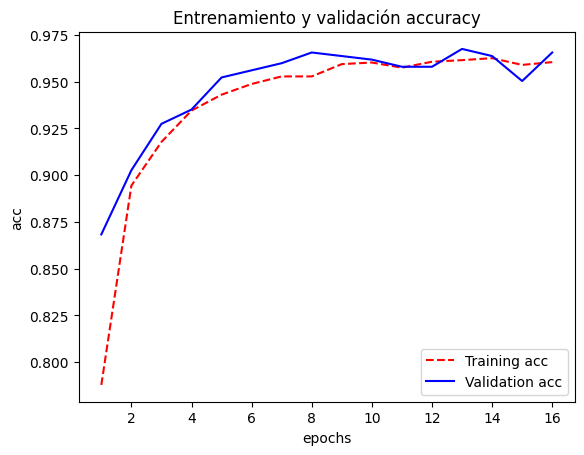

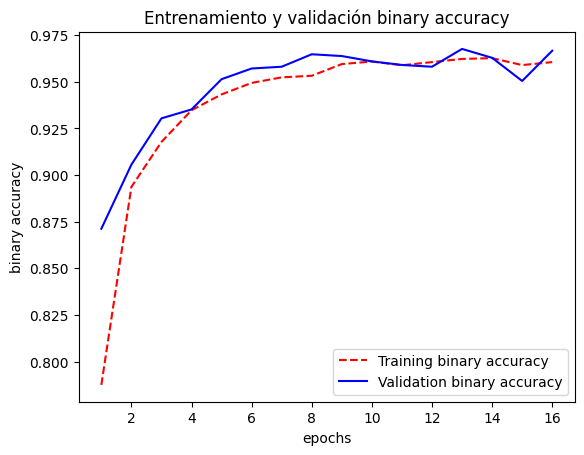

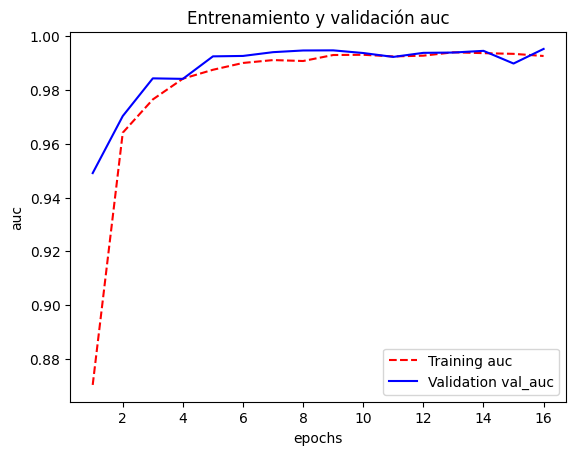

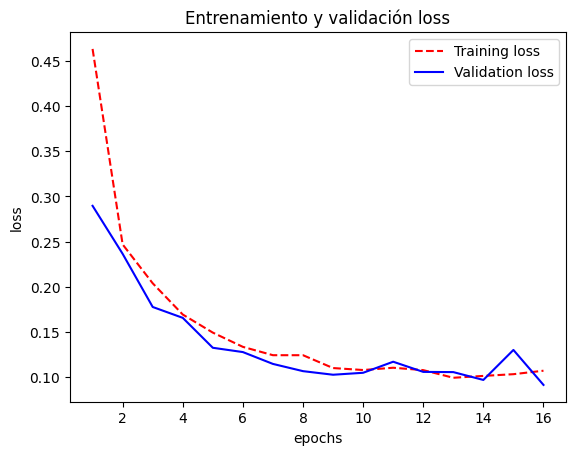

<Figure size 640x480 with 0 Axes>

In [ ]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]
auc = history.history["auc"]
val_auc = history.history['val_auc']
binary_accuracy = history.history['binary_accuracy']
val_binary_accuracy = history.history["val_binary_accuracy"]

epochs   = range(1,len(acc)+1,1)



plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Entrenamiento y validación accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     binary_accuracy, 'r--', label='Training binary accuracy'  )
plt.plot ( epochs, val_binary_accuracy,  'b', label='Validation binary accuracy')
plt.title ('Entrenamiento y validación binary accuracy')
plt.ylabel('binary accuracy')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     auc, 'r--', label='Training auc'  )
plt.plot ( epochs, val_auc,  'b', label='Validation val_auc')
plt.title ('Entrenamiento y validación auc')
plt.ylabel('auc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--' , label='Training loss'  )
plt.plot ( epochs, val_loss ,  'b', label='Validation loss' )
plt.title ('Entrenamiento y validación loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

Predicciones

In [ ]:
predictions = ensemble_model.predict([test_images, test_images, test_images])  # Realizar predicciones en las test_images

20/20 [==============================] - 2s 26ms/step


In [ ]:
# Obtener las clases predichas y las etiquetas reales
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

In [ ]:
# Calcular la exactitud (accuracy) del modelo
accuracy = np.mean(predicted_classes == true_classes)
print("Exactitud del modelo:", accuracy)
# Calcular la precisión del modelo
precision = precision_score(true_classes, predicted_classes)
print("Precisión del modelo:", precision)
# Calcular el recall del modelo
recall = recall_score(true_classes, predicted_classes)
print("Recall del modelo:", recall)
# Calcular el f1-score del modelo
f1 = f1_score(true_classes, predicted_classes)
print("F1-score del modelo:", f1)

Exactitud del modelo: 0.8413461538461539
Precisión del modelo: 0.8063157894736842
Recall del modelo: 0.982051282051282
F1-score del modelo: 0.8855491329479769


Prediccion sin imagen

In [ ]:
index = 1
image = test_images[index]
true_label = test_labels[index]
image = np.expand_dims(image, axis=0)
prediction = ensemble_model.predict([image, image, image])
predicted_class = np.argmax(prediction)
true_class = np.argmax(true_label)
predicted_class_name = class_names[predicted_class]
true_class_name = class_names[true_class]

print("Predicción:", predicted_class_name)
print("Etiqueta real:", true_class_name)

1/1 [==============================] - 1s 583ms/step
Predicción: pneumonia
Etiqueta real: normal


Prediccion 1

1/1 [==============================] - 0s 32ms/step


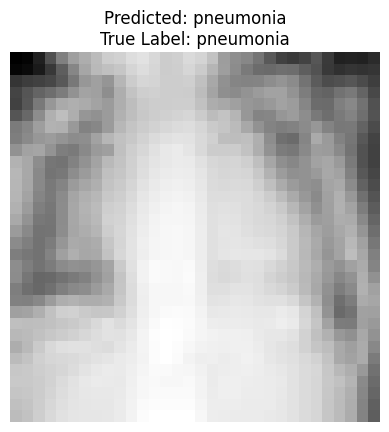

In [ ]:
import matplotlib.pyplot as plt

index = 4
image = test_images[index]
true_label = test_labels[index]
image = np.expand_dims(image, axis=0)
prediction = ensemble_model.predict([image, image, image])
predicted_class = np.argmax(prediction)
true_class = np.argmax(true_label)
predicted_class_name = class_names[predicted_class]
true_class_name = class_names[true_class]

# Display the image
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')

# Add a title with the predicted and true labels
title = f"Predicted: {predicted_class_name}\nTrue Label: {true_class_name}"
plt.title(title)

# Show the plot
plt.show()


Prediccion 2

1/1 [==============================] - 0s 35ms/step


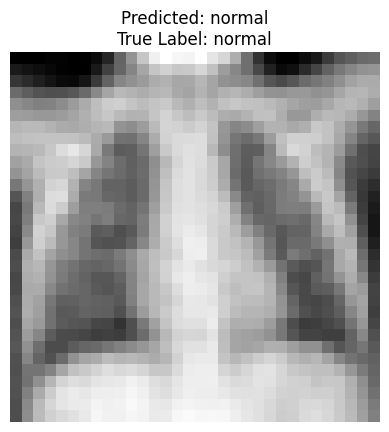

In [ ]:
import matplotlib.pyplot as plt

index = 3
image = test_images[index]
true_label = test_labels[index]
image = np.expand_dims(image, axis=0)
prediction = ensemble_model.predict([image, image, image])
predicted_class = np.argmax(prediction)
true_class = np.argmax(true_label)
predicted_class_name = class_names[predicted_class]
true_class_name = class_names[true_class]

# Display the image
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')

# Add a title with the predicted and true labels
title = f"Predicted: {predicted_class_name}\nTrue Label: {true_class_name}"
plt.title(title)

# Show the plot
plt.show()

Prediccion 3

1/1 [==============================] - 0s 29ms/step


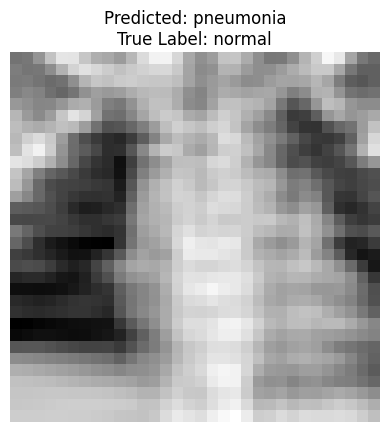

In [ ]:
import matplotlib.pyplot as plt

index = 1
image = test_images[index]
true_label = test_labels[index]
image = np.expand_dims(image, axis=0)
prediction = ensemble_model.predict([image, image, image])
predicted_class = np.argmax(prediction)
true_class = np.argmax(true_label)
predicted_class_name = class_names[predicted_class]
true_class_name = class_names[true_class]

# Display the image
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')

# Add a title with the predicted and true labels
title = f"Predicted: {predicted_class_name}\nTrue Label: {true_class_name}"
plt.title(title)

# Show the plot
plt.show()

Grafico etiquetas

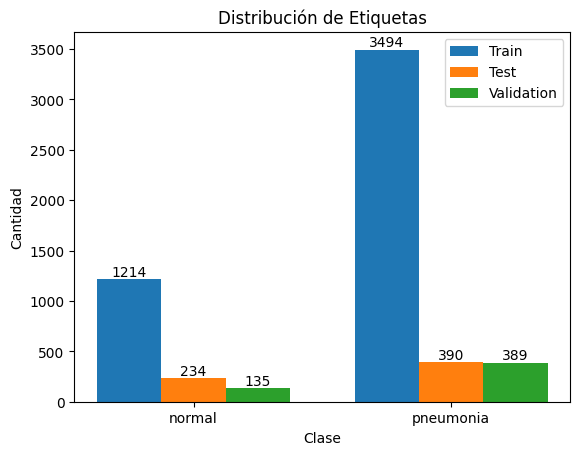

In [ ]:
# Contar la cantidad de ocurrencias de cada etiqueta en los conjuntos de prueba, entrenamiento y validación
train_label_counts = np.bincount(np.argmax(train_labels, axis=1))
test_label_counts = np.bincount(np.argmax(test_labels, axis=1))
val_label_counts = np.bincount(np.argmax(val_labels, axis=1))

# Crear un gráfico de barras
fig, ax = plt.subplots()
x = np.arange(len(class_names))
width = 0.25
train_bars = ax.bar(x - width, train_label_counts, width, label='Train')
test_bars = ax.bar(x, test_label_counts, width, label='Test')
val_bars = ax.bar(x + width, val_label_counts, width, label='Validation')

# Establecer los detalles del gráfico
ax.set_xlabel('Clase')
ax.set_ylabel('Cantidad')
ax.set_title('Distribución de Etiquetas')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Agregar las etiquetas de cantidad en la parte superior de cada barra
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height,
                str(height), ha='center', va='bottom')

autolabel(train_bars)
autolabel(test_bars)
autolabel(val_bars)

# Mostrar el gráfico
plt.show()




Grafico porcentaje distribucion

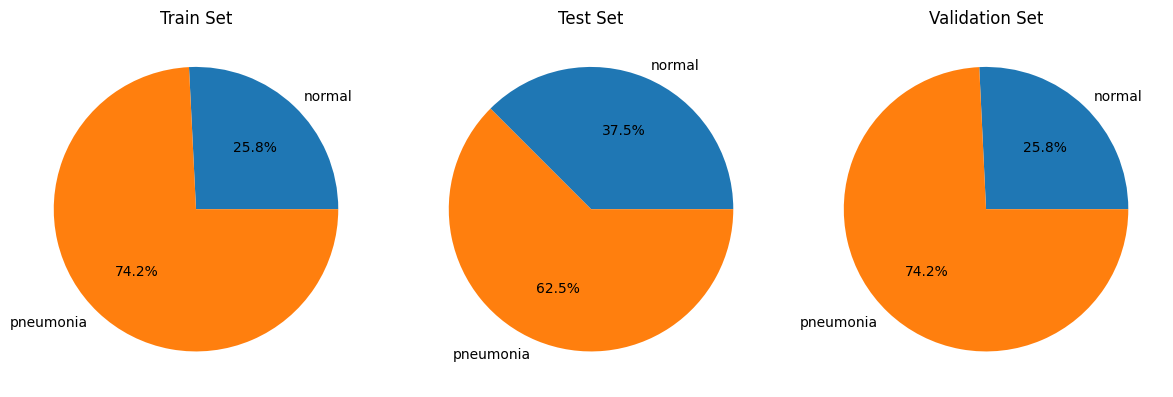

In [ ]:
# Obtener las cantidades de etiquetas en cada conjunto
train_label_counts = np.bincount(np.argmax(train_labels, axis=1))
test_label_counts = np.bincount(np.argmax(test_labels, axis=1))
val_label_counts = np.bincount(np.argmax(val_labels, axis=1))

# Crear subgráficos para cada conjunto
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Gráfico de torta para el conjunto de entrenamiento (train)
ax1.pie(train_label_counts, labels=class_names, autopct='%1.1f%%')
ax1.set_title('Train Set')

# Gráfico de torta para el conjunto de prueba (test)
ax2.pie(test_label_counts, labels=class_names, autopct='%1.1f%%')
ax2.set_title('Test Set')

# Gráfico de torta para el conjunto de validación (validation)
ax3.pie(val_label_counts, labels=class_names, autopct='%1.1f%%')
ax3.set_title('Validation Set')

# Ajustar el diseño de los subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()
